# Xarray Groupby to Extract Single Cell Timeseries

A common task in microscopy data anlaysis is to track the changes of single cell properties over time.

After collecting data you segment and track your cells, so you know which pixels of the image correspond to what cell. But, how do you efficiently convert that mask and fluoresence layer into some a measurement over time for all of your cells.

For example how we would we make this plot:


```{image} images/groupby-cartoon.excalidraw.png
:alt: Time series plot of single flouresence
:class: bg-primary
:width: 600px
:align: center
```


## Enter `Groupby`

Xarray has a solution for this exact problem! The solution is the `groupby`. When you think of `groupby` you likely think of grouping by one-dimensional, for example grouping by time point. 

But Xarray has the power to extend beyond this because it supports [multidimensional coordinates](https://docs.xarray.dev/en/stable/examples/multidimensional-coords.html). This abstraction means that we can use our segmentation mask as multidimensional coordinate. 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


## Simulate data

To keep this example super simple this tutorial will use simulated data. In this case our simluation has spherical cells, with two flouresecent channels and each channel will oscillate in a sin wave, with randomly distributed amplitude, period and offset for each cell. Here is what that looks like. The next cell is collapsed but contains all the code to replicate the data in this example.

In [2]:
# Code based on https://github.com/pymmcore-plus/mda-simulator
import numpy as np
import xarray as xr
from functools import lru_cache
from collections import defaultdict
from skimage.morphology import disk
import numpy as np
from skimage.color import label2rgb
from skimage.draw import disk
class ImageGenerator:
    def __init__(
        self,
        N: int,
        img_shape: tuple[int, int] = (512, 512),
        extent=10,
        radius_loc=25,
        radius_scale=5,
        step_scale: tuple[float, float] = (2.5, 2.5),
        XY_stage_drift: tuple[int, int] = (0, 0),
        snr=1,
        seed=None
    ):
        self._rng = np.random.default_rng(seed)
        self._N = N
        self._ids = np.arange(N)
        self._radii = self._rng.normal(radius_loc, radius_scale, N)
        self._colors = self._rng.random((N, 3))
        self._shape = np.array(img_shape)
        X = self._rng.uniform(-self._shape[0] * extent, self._shape[0] * extent, (N, 1))
        Y = self._rng.uniform(-self._shape[1] * extent, self._shape[1] * extent, (N, 1))
        self._pos = np.hstack((X, Y))
        self._step_scale = np.asarray(step_scale)
        self._stage_drift = np.array(XY_stage_drift)
        self._snr = snr
        # A is per channel
        self._A: dict[int, np.ndarray] = defaultdict(
            lambda: np.abs(self._rng.normal(1024, 256))
        )
        # sigma dict is per cell/per channel
        self._sigma: dict[int, np.ndarray] = defaultdict(
            lambda: 1
            + np.abs(self._rng.normal(radius_loc / 10, radius_scale / 10, size=self._N))
        )
        self._tau: dict[int, np.ndarray] = defaultdict(
            lambda: 1.5+1.5*np.abs(self._rng.normal(size=self._N))
        )
        self._phase: dict[int, np.ndarray] = defaultdict(
            lambda: self._rng.uniform(0, 2*np.pi,size=self._N)
        )
        self._t = 0

    @property
    def snr(self) -> float:
        return self._snr

    @snr.setter
    def snr(self, val: float):
        # TODO: add validation
        self._snr = val

    @property
    def img_shape(self) -> np.ndarray:
        return self._shape

    def snap_img(self, xy: tuple[float, float], c: int = 0, z: float = 0, exposure=1):
        return self._snap_img(tuple(xy), c, z, exposure)

    @lru_cache(256)
    def _snap_img(self, xy: tuple[float, float], c: int = 0, z: float = 0, exposure=1):
        x_idx = (self._pos[:, 0] < xy[0] + self._shape[0] // 2) & (
            self._pos[:, 0] > xy[0] - self._shape[0] // 2
        )
        y_idx = (self._pos[:, 1] < xy[1] + self._shape[1] // 2) & (
            self._pos[:, 1] > xy[1] - self._shape[1] // 2
        )
        idx = x_idx & y_idx

        coords = self._pos[idx] + (self._shape / 2 - np.asarray(xy))[None, :]
        radii = self._radii[idx]
        inter = radii**2 - z**2
        inter[inter < 0] = 0
        radii = np.sqrt(inter)
        ids = self._ids[idx]
        if c=='mask':
            sigmas = self._sigma[c][idx]
            taus = self._tau[c][idx]
            phases = self._phase[c][idx]
            A = self._A[c]
        else:
            sigmas = self._sigma[c][idx]
            taus = self._tau[c][idx]
            A = self._A[c]
            phases = self._phase[c][idx]
            

        out = np.zeros(self._shape, dtype=np.int16)

        
        for pos, r, id_, sigma, tau, phase in zip(coords, radii, ids, sigmas, taus, phases):
            pixels = disk(pos, r, shape=self._shape)
            if isinstance(c, (int, float)) and c > 0:
                dists = np.sqrt((pixels[0] - pos[0]) ** 2 + (pixels[1] - pos[1]) ** 2)
                intensity = exposure * A * np.exp(-dists / (2 * sigma**2)) *(2-np.sin(self._t/tau+phase))
            elif c=='mask':
                intensity=id_
            else:
                intensity = A
            out[pixels] = intensity
        # todo: make this poisson
        if c!='mask':
            out = out + self._rng.normal(0, A / self._snr, size=self._shape)
        out[out < 0] = 0
        return out.T

    def increment_time(self, delta_t=1):
        """increment the simulation time by delta_t time units."""
        # clear the cache as the image will have changed
        self._snap_img.cache_clear()

        self._pos += self._rng.normal(
            scale=self._step_scale * delta_t, size=(self._N, 2)
        ) + np.array(self._stage_drift)
        self._t += delta_t

def make_groupby_data(seed):
    T = 40
    C = 3
    Y, X = 512, 512
    da = xr.DataArray(
        np.zeros([T, C, Y, X]),
        dims=("T", "C", "Y", "X"),
        coords={"C": ["BF", "GFP", "RFP"]},
    )
    masks = xr.DataArray(np.zeros([T, Y, X], dtype=np.uint16), dims=("T", "Y", "X"))
    gen = ImageGenerator(N=3500, snr=15, step_scale=12, seed=seed)
    for t in range(T):
        da[t, 0] = gen.snap_img(xy=(0, 0), exposure=10, c=0)
        da[t, 1] = gen.snap_img(xy=(0, 0), exposure=10, c=1)
        da[t, 2] = gen.snap_img(xy=(0, 0), exposure=10, c=2)
        masks[t] = gen.snap_img(xy=(0, 0), c="mask").astype(np.uint16)
        gen.increment_time(0.5)
    ds = xr.Dataset({"images": da}, coords={"cell_id": masks})
    return ds

In [3]:
ds = make_groupby_data(seed=1024)

## A quick look at the data

Here you can see the simulated data. Spherical cells that move around according to a random walk. Each cell constitutively expresses both GFP and RFP with intensity varying over time.

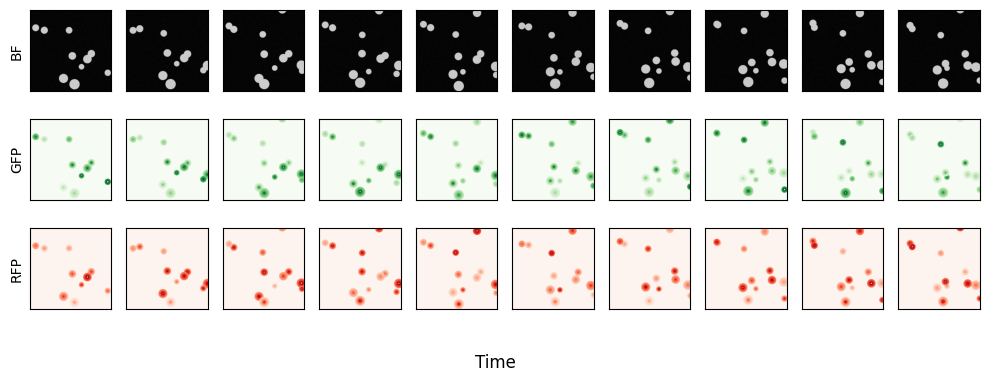

In [4]:
fig, axs = plt.subplots(3, 10, sharex=True, sharey=True, figsize=(10,4))

cmaps = {0:'gray', 1:'Greens', 2:'Reds'}
for c, C in enumerate(ds.C):
    for t, T in enumerate(np.arange(0,40, 40//10)):
        axs[c,t].imshow(ds['images'].sel(T=T, C=C), cmap=cmaps[c])
        # axs[c, t].axis('off')
        axs[c,t].set_xticks([])
        axs[c,t].set_yticks([])
fig.supxlabel("Time")
axs[0,0].set_ylabel("BF")
axs[1,0].set_ylabel("GFP")
axs[2,0].set_ylabel("RFP")
plt.tight_layout()

Looking at the Xarray repr we can see that the `cell_id` was included as coordinate variable. In this case the knowledge of what pixel corresponds to what cell at any given timepoint is more metadata than data. So we have included it as a coordinate. However can also include it as a data variable if that makes more sense in your application. However, in order to do groupby you will need it to be a coordinate variable.

In [5]:
ds

<xarray.Dataset> Size: 273MB
Dimensions:  (C: 3, T: 40, Y: 512, X: 512)
Coordinates:
  * C        (C) <U3 36B 'BF' 'GFP' 'RFP'
    cell_id  (T, Y, X) uint16 21MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: T, Y, X
Data variables:
    images   (T, C, Y, X) float64 252MB 2.493 115.6 0.0 0.0 ... 3.729 0.0 0.0

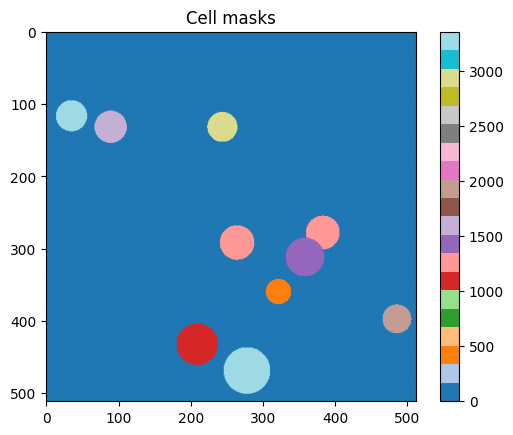

In [6]:
# taking a quick look at the masks
plt.figure()
plt.imshow(ds['cell_id'].sel(T=0), cmap='tab20')
plt.title("Cell masks")
plt.colorbar()

Now we are ready to use groupby to extract single cell properties in time. Groupby works on a split-apply-combine principle. So the first step is to split up our data by individual cell. To do this we simply let Xarray know what coordinate variable to make into groups.


In this case there were 12 unique cells in our field of view (+1 group for the background with `cell_id=0`) so our grouper will have 13 groups.

In [7]:
# construct the groupby
per_cell_groupby = ds.groupby(["cell_id"])
print(per_cell_groupby)

<DatasetGroupBy, grouped over 1 grouper(s), 13 groups in total:
    'cell_id': UniqueGrouper('cell_id'), 13/13 groups with labels 0, 270, 409, ..., 2987, 3282, 3353>


To turn this into a reasonable plot we now need to **apply** an aggregation function. In our case of tracking a cell cycle marker that can be as simple as calling the mean, but can you write arbitrarily complex reductions and apply them. 


In [8]:
# Aggregate over our spatial dimensions
spatial_averaged = per_cell_groupby.mean(["X", "Y"], fill_value=np.nan)

# drop the background
spatial_averaged = spatial_averaged.drop_sel({"cell_id": 0}).rename({"images":"cell_avg"})

spatial_averaged

<xarray.Dataset> Size: 12kB
Dimensions:   (T: 40, C: 3, cell_id: 12)
Coordinates:
  * C         (C) <U3 36B 'BF' 'GFP' 'RFP'
  * cell_id   (cell_id) uint16 24B 270 409 1134 1235 ... 1976 2987 3282 3353
Dimensions without coordinates: T
Data variables:
    cell_avg  (T, C, cell_id) float64 12kB nan 1.188e+03 ... 2.222e+04 9.988e+03

Notice that the `cell_id` coordinate is now one dimensional, reflecting the fact that we have removed the spatial component through our grouping and aggregation.

This mekes it easy to use Xarray's plotting functionality to automatically plot single cell traces of GFP and RFP as a function of time.

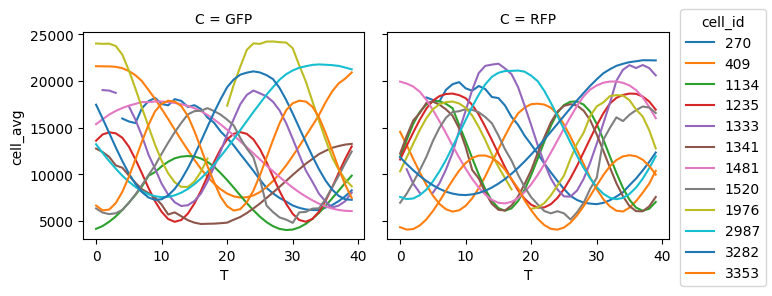

In [9]:
spatial_averaged.sel(C=["GFP", "RFP"]).cell_avg.plot(hue="cell_id", col="C")

While this is is a simple example, it demonstrates a powerful paradigm. You can apply arbitary aggregation functions in the groupby in order to easily compute any single cell property as a function of time. 

For a small example you might have been able to write this as a for loop, but has your datasets grow larger using Xarray's groupby can yield significant performance improvements because of how it uses `flox` to speed up out of memory groupbys. WHich you can read more about here: [https://xarray.dev/blog/flox](https://xarray.dev/blog/flox)